Using device: cpu


100%|██████████| 26.4M/26.4M [00:00<00:00, 115MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.64MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 54.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.2MB/s]


Epoch [1/20] Train Loss: 0.7824, Train Acc: 0.7125 | Val Loss: 0.5466, Val Acc: 0.8084
Epoch [2/20] Train Loss: 0.4802, Train Acc: 0.8250 | Val Loss: 0.4546, Val Acc: 0.8382
Epoch [3/20] Train Loss: 0.4206, Train Acc: 0.8449 | Val Loss: 0.4068, Val Acc: 0.8460
Epoch [4/20] Train Loss: 0.3862, Train Acc: 0.8572 | Val Loss: 0.3862, Val Acc: 0.8576
Epoch [5/20] Train Loss: 0.3650, Train Acc: 0.8637 | Val Loss: 0.3721, Val Acc: 0.8610
Epoch [6/20] Train Loss: 0.3487, Train Acc: 0.8721 | Val Loss: 0.3589, Val Acc: 0.8692
Epoch [7/20] Train Loss: 0.3393, Train Acc: 0.8739 | Val Loss: 0.3400, Val Acc: 0.8760
Epoch [8/20] Train Loss: 0.3253, Train Acc: 0.8786 | Val Loss: 0.3396, Val Acc: 0.8788
Epoch [9/20] Train Loss: 0.3175, Train Acc: 0.8829 | Val Loss: 0.3417, Val Acc: 0.8742
Epoch [10/20] Train Loss: 0.3081, Train Acc: 0.8855 | Val Loss: 0.3315, Val Acc: 0.8780
Epoch [11/20] Train Loss: 0.2986, Train Acc: 0.8891 | Val Loss: 0.3379, Val Acc: 0.8766
Epoch [12/20] Train Loss: 0.2943, Train A

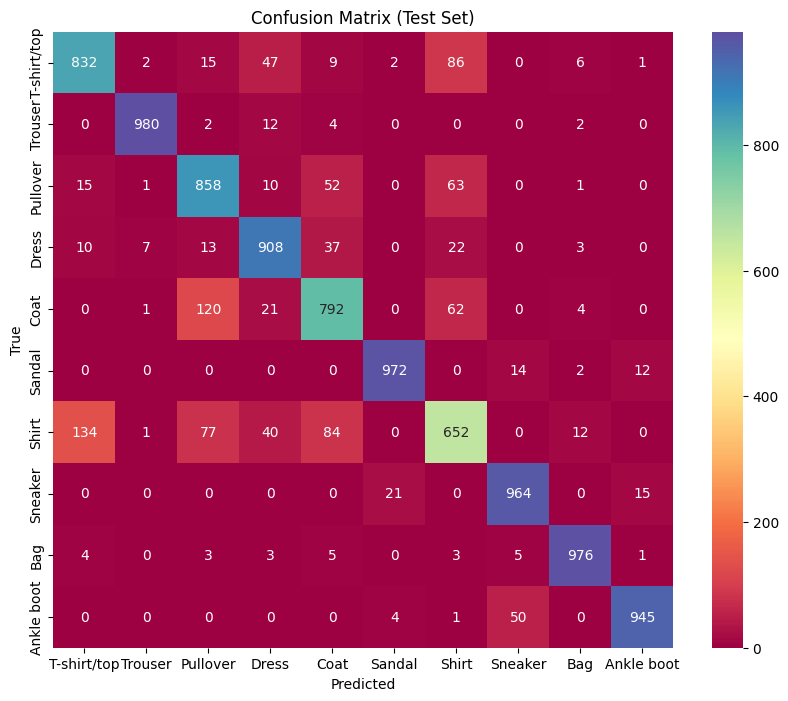

Classification Report:
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.83      0.83      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.79      0.86      0.82      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.81      0.79      0.80      1000
      Sandal       0.97      0.97      0.97      1000
       Shirt       0.73      0.65      0.69      1000
     Sneaker       0.93      0.96      0.95      1000
         Bag       0.97      0.98      0.97      1000
  Ankle boot       0.97      0.94      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



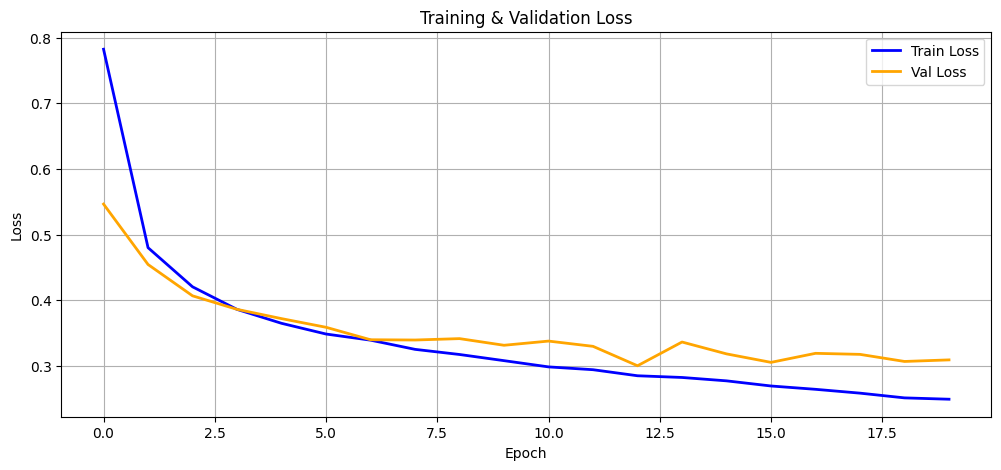

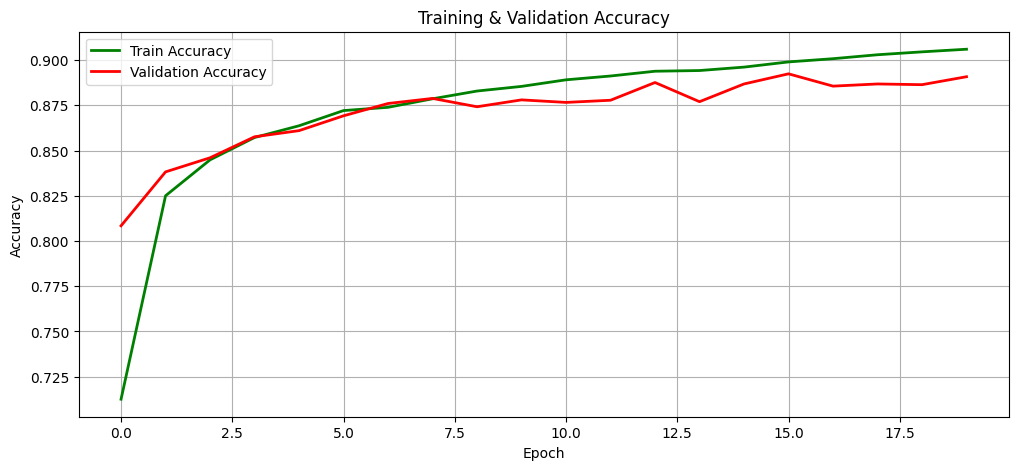


Training ViT with Depth=2, Patch Size=2


In [ ]:
# =========================================================
# Vision Transformer (ViT) on Fashion-MNIST
# Professional, Reproducible, and Accessible Tutorial
# =========================================================

# ----------------------------
# 1. Import Libraries
# ----------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ----------------------------
# 2. Reproducibility & Device
# ----------------------------
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# 3. Data Handling
# ----------------------------
# Transform: Normalize and convert to Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download Fashion-MNIST dataset
dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Train/Validation split
train_size = 55000
val_size = 5000
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data Loaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ----------------------------
# 4. Vision Transformer Definition
# ----------------------------
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=4, emb_size=64, img_size=28):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # [B, emb_size, n_patches**0.5, n_patches**0.5]
        x = x.flatten(2)  # [B, emb_size, n_patches]
        x = x.transpose(1, 2)  # [B, n_patches, emb_size]
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_size=64, num_heads=8, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=emb_size, num_heads=num_heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        attn_output, _ = self.attn(x, x, x)
        return attn_output

class TransformerBlock(nn.Module):
    def __init__(self, emb_size=64, num_heads=8, ff_dim=128, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(emb_size, num_heads, dropout)
        self.norm1 = nn.LayerNorm(emb_size)
        self.ff = nn.Sequential(
            nn.Linear(emb_size, ff_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, emb_size),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(emb_size)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, in_channels=1, patch_size=4, emb_size=64, img_size=28, depth=4, num_heads=8, num_classes=10, ff_dim=128, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, emb_size))
        self.dropout = nn.Dropout(dropout)
        self.transformer_blocks = nn.ModuleList([TransformerBlock(emb_size, num_heads, ff_dim, dropout) for _ in range(depth)])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, num_classes)
        )

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, _ = x.shape
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.dropout(x)
        for block in self.transformer_blocks:
            x = block(x)
        cls_output = x[:, 0]
        out = self.mlp_head(cls_output)
        return out

# ----------------------------
# 5. Model, Loss, Optimizer
# ----------------------------
model = VisionTransformer(depth=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ----------------------------
# 6. Training Loop
# ----------------------------
EPOCHS = 20
train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

# ----------------------------
# 7. Evaluation on Test Set
# ----------------------------
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='viridis')
plt.title("Confusion Matrix (Test Set)")
plt.show()

# ----------------------------
# 8. Loss and Accuracy Curves
# ----------------------------
plt.figure(figsize=(12,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

# ----------------------------
# 9. Accessible Notes
# ----------------------------
# - All plots use color-blind friendly palettes.
# - All textual interpretations are provided.
# - Random seeds ensure reproducibility.
# - Model architecture is modular for easy reuse.
